In [2]:
from cv_dataset import CVDataset
from training import ensemble_evaluate, train
from unet import UnetDensenet
from utils import CreateBaseTransforms, CreateEnsembleTransforms

import matplotlib.pyplot as plt
import numpy as np

import json

import torch

from monai.apps import (
    CrossValidation
)

from monai.data import (
    DataLoader,
    Dataset, 
    partition_dataset,
)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
sns.set_style("white")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
dataset_path = '/home/marcello/Repositories/DICOM-Project-Pytorch/data/dataset1/dataset1.json'

with open(dataset_path, 'r') as file:
    dataset = json.load(file)

image_paths = [item['image'] for item in dataset['data']]
labels = [item['label'] for item in dataset['data']]

data = list(zip(image_paths, labels))

data_list, test_data = partition_dataset(
    data, ratios=[0.85, 0.15], shuffle=True, seed=42
)

In [4]:
train_val_images = [{"image": img, "label": label} for img, label in data_list]
test_images = [{"image": img, "label": label} for img, label in test_data]

In [5]:
num = 5
folds = list(range(num))

cvdataset = CrossValidation(
    dataset_cls=CVDataset,
    data=train_val_images,
    nfolds=num,
    seed=12345,
    transform=CreateBaseTransforms(),
)

train_dataset = [cvdataset.get_dataset(folds=folds[0:i] + folds[(i + 1) :]) for i in folds]

val_dataset = [cvdataset.get_dataset(folds=i, transform=CreateBaseTransforms()) for i in range(num)]

test_dataset  = Dataset(
    data=test_images, 
    transform=CreateBaseTransforms())

Loading dataset: 100%|██████████| 38/38 [00:00<00:00, 908.19it/s]


In [6]:
train_loaders = [DataLoader(train_dataset[i], batch_size=1, shuffle=True, num_workers=4, pin_memory=False) for i in folds]
val_loaders = [DataLoader(val_dataset[i], batch_size=1, num_workers=4, pin_memory=False) for i in folds]
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=4)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UnetDensenet((224, 224, 1)).to(device)

decoder_filters_in [1024, 256, 128, 64, 32] decoder_filters (256, 128, 64, 32, 16)
upsample_blocks[0]
in: 1024
out: 256

skip_in 1024
upsample_blocks[1]
in: 256
out: 128

skip_in 512
upsample_blocks[2]
in: 128
out: 64

skip_in 256
upsample_blocks[3]
in: 64
out: 32

skip_in 64
upsample_blocks[4]
in: 32
out: 16

skip_in 0


In [8]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 224, 224])


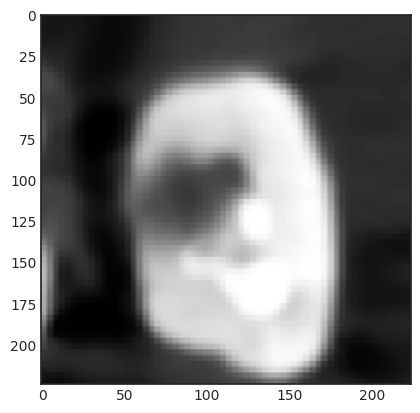

In [9]:
images = 0
imgs = []

for i in train_loaders[0]:
    if images == 4:
        break
    
    images += 1
    print(i['image'].shape)
    imgs.append(i['image'])

npimg = torch.squeeze(imgs[0], dim=1).squeeze(0).numpy()
plt.imshow(npimg,cmap='gray')
plt.show()

In [10]:
models = []

for i in range(num):
    print(f'---------------Training for fold {i}---------------')
    models.append(train(train_loaders[i], val_loaders[i], model, device))

---------------Training for fold 0---------------
Training with 100 epochs
2024-10-01 20:40:25,206 - INFO - Epoch: 1/100, Iter: 1/153 -- train_loss: 1.6562 
2024-10-01 20:40:25,270 - INFO - Epoch: 1/100, Iter: 2/153 -- train_loss: 1.6616 
2024-10-01 20:40:25,326 - INFO - Epoch: 1/100, Iter: 3/153 -- train_loss: 1.6522 
2024-10-01 20:40:25,390 - INFO - Epoch: 1/100, Iter: 4/153 -- train_loss: 1.6573 
2024-10-01 20:40:25,446 - INFO - Epoch: 1/100, Iter: 5/153 -- train_loss: 1.6576 
2024-10-01 20:40:25,502 - INFO - Epoch: 1/100, Iter: 6/153 -- train_loss: 1.6604 
2024-10-01 20:40:25,558 - INFO - Epoch: 1/100, Iter: 7/153 -- train_loss: 1.6465 
2024-10-01 20:40:25,616 - INFO - Epoch: 1/100, Iter: 8/153 -- train_loss: 1.6595 
2024-10-01 20:40:25,673 - INFO - Epoch: 1/100, Iter: 9/153 -- train_loss: 1.6598 
2024-10-01 20:40:25,731 - INFO - Epoch: 1/100, Iter: 10/153 -- train_loss: 1.6548 
2024-10-01 20:40:25,790 - INFO - Epoch: 1/100, Iter: 11/153 -- train_loss: 1.6558 
2024-10-01 20:40:25,8

In [11]:
print(len(models))

5


In [11]:
mean_post_transforms = CreateEnsembleTransforms(len(models))

ensemble_evaluate(mean_post_transforms, models, test_loader, device)

{rank: 0, best_validation_epoch: 1, best_validation_metric: 0.2639259397983551}

In [13]:
last_model = models[4]

In [14]:
last_model.eval()

UnetDensenet(
  (backbone): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): Batch

torch.float32


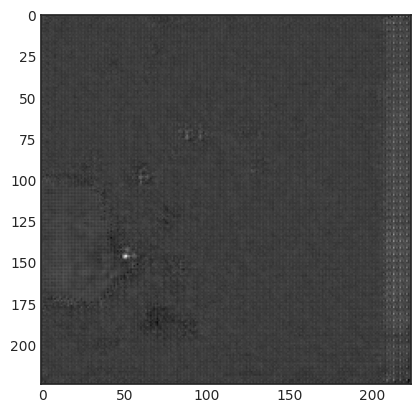

torch.float32


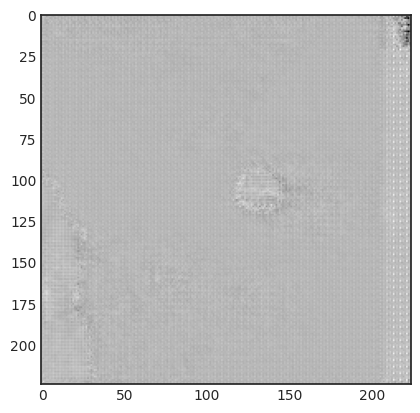

torch.float32


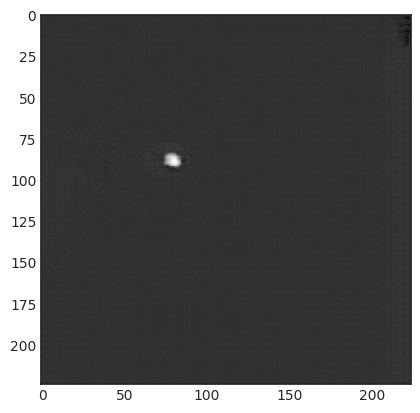

torch.float32


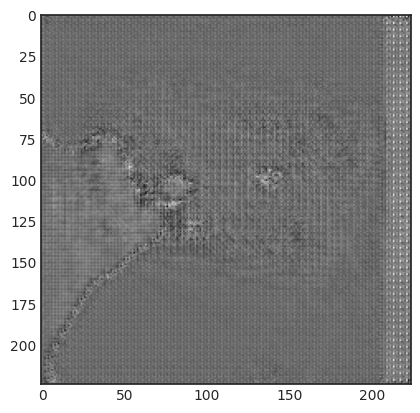

torch.float32


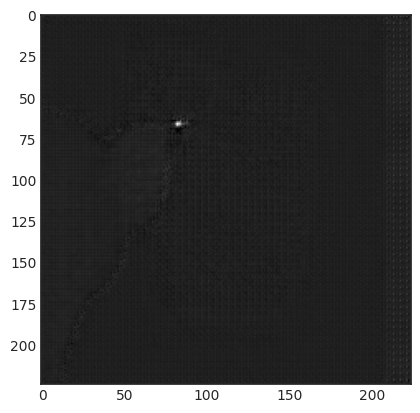

torch.float32


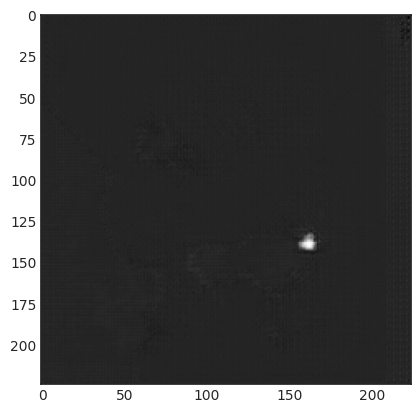

torch.float32


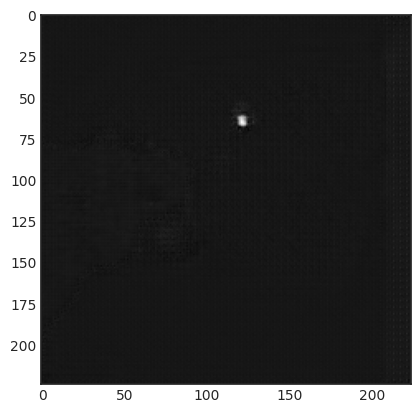

torch.float32


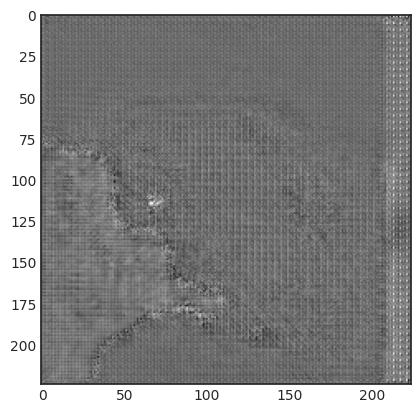

torch.float32


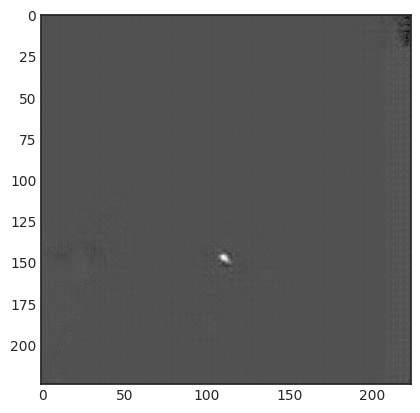

torch.float32


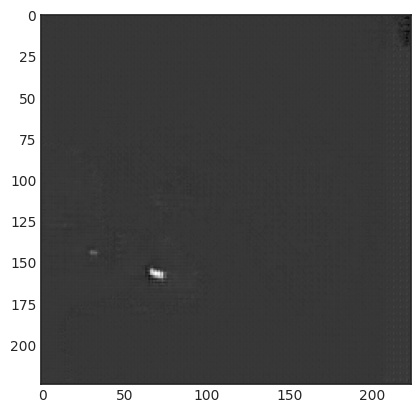

In [18]:
images = 0
imgs = []

import cv2

for batch_data in test_loader:
    if images == 10:
        break
    
    inputs = batch_data["image"].to(device)
    outputs = model(inputs)

    print(outputs.dtype)
    
    img_squeezed = inputs.squeeze()
    img_numpy = img_squeezed.cpu().detach().numpy()

    pred_squeezed = outputs.squeeze()
    pred_numpy = pred_squeezed.cpu().detach().numpy()

    img_gray_image = cv2.normalize(img_numpy, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    
    pred_gray_image = cv2.normalize(pred_numpy, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

    image_with_mask = img_gray_image.copy()
    image_with_mask[pred_gray_image == 1] = image_with_mask[pred_gray_image == 1] * 0.05
    
    plt.imshow(pred_gray_image,cmap='gray')
    plt.show()
    images+=1
    

In [28]:
pred = last_model(image_reversed)

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
